## Setup

In [3]:
import numpy as np
import pandas as pd

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_days_to_pref_cost, cal_total_preference, cal_total_accounting
)
from util_check import deep_check

In [4]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
#path_init_conf =     '../output/m08-improved.csv'
path_init_conf =     '../input/another_pytorch_implementation.csv'
path_dump_improved = '../output/m11-improved.csv' # lowest cost
num_cpu_cores = 12
time_limit = 9*60*60*1000  # in ms
#time_limit = 60*1000  # in ms

In [5]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
print('Total score:    ', cal_total(assigned_day, occupancy))
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
Total score:     71252.41958450396
Preference cost: 65785
Accounting cost: 5467.419584503968


In [6]:
families = range(N_families)
days = range(1, N_days + 1)

In [7]:
allowed_occupancy = range(N_min_people, N_max_people+1)

## Ortools - CBC MIP solver

In [8]:
from ortools.linear_solver import pywraplp

In [9]:
solver = pywraplp.Solver('', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

In [10]:
print('Set num threads:', solver.SetNumThreads(num_cpu_cores))
print('Set time limit:', solver.SetTimeLimit(time_limit))

Set num threads: True
Set time limit: None


## Variables

In [11]:
# Variables
assignment_matrix = {}
for family in families:
    for day in days:
        assignment_matrix[family, day] = solver.BoolVar('x[%i,%i]' % (family, day))

In [12]:
len(assignment_matrix)

500000

## Constraints

In [13]:
# Constraints
# each family only take 1 day
for family in families:
    solver.Add(
        solver.Sum([assignment_matrix[family, day] for day in days]) == 1
    )

In [14]:
# # each day can only have 1 occupancy number
# for day in days:
#     solver.Add(
#         solver.Sum([occupancy_matrix[day, people] for people in allowed_occupancy]) == 1
#     )

In [15]:
for day in days:
    solver.Add(
        solver.Sum(
            [assignment_matrix[family, day] * n_people[family] for family in families]
        ) <= N_max_people
    )
    solver.Add(
        solver.Sum(
            [assignment_matrix[family, day] * n_people[family] for family in families]
        ) >= N_min_people
    )

In [16]:
len(solver.constraints())

5200

## Objective

### Linearized accounting cost

In [17]:
occupancy.shape

(102,)

In [18]:
occupancy

array([125, 300, 286, 300, 300, 283, 257, 244, 244, 266, 293, 300, 299,
       276, 261, 253, 268, 292, 290, 271, 244, 220, 225, 250, 277, 297,
       289, 271, 255, 245, 242, 270, 273, 253, 220, 193, 162, 197, 231,
       254, 236, 205, 176, 188, 210, 248, 267, 249, 223, 196, 175, 212,
       246, 245, 221, 185, 152, 125, 219, 246, 231, 201, 160, 125, 125,
       125, 243, 214, 177, 131, 125, 125, 125, 223, 201, 171, 126, 125,
       125, 125, 222, 205, 171, 125, 126, 126, 125, 249, 229, 199, 157,
       125, 125, 125, 230, 208, 175, 128, 125, 125, 125, 125], dtype=int32)

In [19]:
diff_nd_ndp1 = np.concatenate([np.diff(occupancy), [0]])

In [20]:
sign_diff_nd_ndp1 = 1 * (diff_nd_ndp1 > 0) - 1 * (diff_nd_ndp1 < 0)

In [21]:
abs_nd_ndp1 = np.abs(diff_nd_ndp1)

In [22]:
# first derivative of accounting cost with respect to N_d (occupancy at day d) at N_d
dadnd = (
    occupancy**(0.5 + abs_nd_ndp1/50) / 400 * (
        1 + (occupancy - 125) * (
            (0.5 + abs_nd_ndp1 / 50) / occupancy + np.log(occupancy) / 50 * sign_diff_nd_ndp1
        )
    )
)

In [23]:
# first derivative of accounting cost with respect to N_d+1 (occupancy at day d+1) at N_d
dadnp1d = (
    occupancy**(0.5 + abs_nd_ndp1/50) / 400 * (
        (occupancy - 125) * (
            -1 * np.log(occupancy) / 50 * sign_diff_nd_ndp1
        )
    )
)
dadnp1d = np.concatenate([[0.], dadnp1d[:-1]])  # since this contribute to the N_d+1 term, we shift it by 1 day

In [24]:
da = dadnd + dadnp1d  # total gradient w.r.t N_d

In [25]:
da.shape

(102,)

In [26]:
# Objective - Preference cost + linearized accounting cost
solver.Minimize(
    # preference cost
    solver.Sum([
        assignment_matrix[family, day] * family_id_days_to_pref_cost[family, day]
        for family in families for day in days
    ])
    # linearized accounting cost
    + solver.Sum([
        (
            solver.Sum([
                assignment_matrix[family, day] * n_people[family]
                for family in families
            ]) - occupancy[day]
        ) * da[day]
        for day in days
    ])
)

## Warm start

In [27]:
solver.SetHint(
    [assignment_matrix[family, day] for family in families for day in days],
    [float(assigned_day[family]==day) for family in families for day in days]
)

## Solve

In [28]:
print('N of variables', len(solver.variables()))

N of variables 500000


In [ ]:
%%time
# Solve
sol = solver.Solve()

resdict = {0:'OPTIMAL', 1:'FEASIBLE', 2:'INFEASIBLE', 3:'UNBOUNDED', 
           4:'ABNORMAL', 5:'MODEL_INVALID', 6:'NOT_SOLVED'}
print('Result: ', resdict[sol])
print('Total cost: ', solver.Objective().Value())
print("Time: ", solver.WallTime(), " milliseconds")

## Solution

In [28]:
assigned_day_new = np.array([
    [0]+[assignment_matrix[family, day].solution_value() for day in days]
    for family in families
]).argmax(axis=1)

In [29]:
assigned_day_new.max()

100

In [30]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)

occupancy_new = assigned_day_to_occupancy(assigned_day_new)

deep_check(assigned_day_new, family_on_day_new, occupancy_new)

deep check: everything looks fine.


True

In [31]:
print('[New]')
print('Total score:    ', cal_total(assigned_day_new, occupancy_new))
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

[New]
Total score:     21840296486.246655
Preference cost: 51722
Accounting cost: 21840244764.246655


In [32]:
print('[Before]')
print('Total score:    ', cal_total(assigned_day, occupancy))
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

[Before]
Total score:     73610.22770050484
Preference cost: 68372
Accounting cost: 5238.227700504839


In [33]:
# Without accounting cost - 1min
# Total score:     13985688754.836958
# Preference cost: 44894
# Accounting cost: 13985643860.836958

## Output

In [34]:
#dump_conf(assigned_day_new, path_dump_improved)

## Analysis

In [35]:
import matplotlib.pyplot as plt

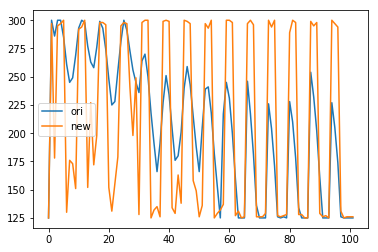

In [36]:
plt.plot(occupancy, label='ori')
plt.plot(occupancy_new, label='new')
plt.legend()
plt.show()